<a href="https://colab.research.google.com/github/alfinmaulani/skripsi/blob/master/combined(glove).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade scikit-learn
import numpy as np
import pandas as pd
import io
import os
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
import gensim

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
url0='https://raw.githubusercontent.com/alfinmaulani/skripsi/master/dataISEAR.csv'
df = pd.read_csv(url0)

In [ ]:
# df=df.drop(df[df['emosi'] == 'shame'].sample(frac=1).index)
# df=df.drop(df[df['emosi'] == 'guilt'].sample(frac=1).index)

In [3]:
df.emosi.value_counts()

joy        1092
sadness    1082
anger      1079
fear       1076
shame      1071
disgust    1066
guilt      1050
Name: emosi, dtype: int64

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df2 = pd.read_csv('/content/drive/MyDrive/twitter_prosessed.csv')

In [6]:
df3 = pd.read_csv('/content/drive/MyDrive/idwiki_new_lower.txt', delimiter = "\t")
df3.columns = ["arti"]

In [ ]:
df4 = pd.read_csv('/content/drive/MyDrive/idwiki_new_lower2.txt', delimiter = "\t")
df4.columns = ["arti"]

persiapan corpus tambahan

In [ ]:
# dfg = pd.DataFrame(df2.tweet,columns=["dok"])

In [ ]:
# dfg = pd.DataFrame(df3.arti,columns=["dok"])

In [7]:
dfg = pd.DataFrame(df3.arti.append(df2.tweet,ignore_index=True),columns=["dok"])

preputama : lower case

In [8]:
def lower(temp):
  return temp.str.lower()

In [9]:
df['dokumen']=lower(df['dokumen'])

In [10]:
dfg['dok']=lower(dfg['dok'])

preputama : Pembersihan noise (over enter and space)

In [11]:
def bersih_noise(temp):
  temp=temp.replace(' \n', ' ', regex=True)
  temp=temp.replace('   ', ' ', regex=True)
  return temp.replace('  ', ' ', regex=True)

In [12]:
df=bersih_noise(df)

In [13]:
dfg=bersih_noise(dfg)

preptambah : expand contractions

In [14]:
!pip install contractions
import contractions

     |████████████████████████████████| 321 kB 9.5 MB/s 
     |████████████████████████████████| 284 kB 45.3 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85452 sha256=22da2d6139fbb9c41021a9e1d482c74c5c5562c79fc77dd276060fcdd10c265c
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [15]:
def expand_word(temp):
  expanded_words = []   
  for word in temp:
    expanded_words.append(contractions.fix(word))
  return expanded_words

In [16]:
df.dokumen=expand_word(df.dokumen)

In [17]:
dfg.dok=expand_word(dfg.dok)

preputama : cleansing punctuation

In [18]:
def clns_punc(temp):
  return temp.str.replace(r'[^\w\s]+', '')

In [19]:
df['dokumen'] = clns_punc(df['dokumen'])

In [20]:
dfg['dok'] = clns_punc(dfg['dok'])

preputama : cleansing number

In [21]:
!pip install tweet-preprocessor
import preprocessor as p

In [22]:
p.set_options(p.OPT.NUMBER)
def clns_numb(temp):
  sementara=[]
  for word in temp:
    sementara.append(p.clean(word))
  return sementara

In [23]:
df.dokumen=clns_numb(df.dokumen)

In [24]:
dfg.dok=clns_numb(dfg.dok)

preptambah : remove stopword

In [25]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [26]:
pat = r'\b(?:{})\b'.format('|'.join(stop))
def remove_stopw(temp):
  temp=temp.str.replace(pat, '')
  return temp.str.replace(r'\s+', ' ')

In [27]:
df['dokumen'] = remove_stopw(df['dokumen'])

In [28]:
dfg['dok'] = remove_stopw(dfg['dok'])

tokenizing

In [29]:
def token(temp):
  return [word_tokenize(x) for x in temp]

In [30]:
df.dokumen=token(df.dokumen)

In [31]:
dfg.dok=token(dfg.dok)

preptambah : Lemmatization

In [32]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [33]:
def lemma(temp):
  temp.apply(lambda x: [stemmer.stem(y) for y in x])

In [34]:
lemma(df['dokumen'])

In [35]:
lemma(dfg['dok'])

save df

In [ ]:
# df.to_csv(r'dataisear(preptambah).csv', index = False)

gabung corpus

In [ ]:
# sent=df.dokumen

In [36]:
sent=dfg.dok.append(df.dokumen,ignore_index=True)

glove

In [37]:
!pip install glove-python-binary

     |████████████████████████████████| 948 kB 6.2 MB/s 


In [38]:
from glove import Glove
from glove import Corpus

In [39]:
korpus = Corpus()
korpus.fit(sent, window=5, ignore_missing=False,)

In [ ]:
# (corpus, window=10, ignore_missing=False)

In [40]:
glove = Glove(no_components=100, learning_rate=0.05, alpha=0.025, max_count=100, max_loss=10.0, random_state=None)
glove.fit(korpus.matrix)
glove.add_dictionary(korpus.dictionary)

In [ ]:
# (no_components=30, learning_rate=0.05, alpha=0.75, max_count=100, max_loss=10.0, random_state=None)

cek model

In [41]:
glove.word_vectors.shape

(1003499, 100)

In [42]:
glove.word_vectors[glove.dictionary['moment']]

array([-0.23648805, -0.2554184 , -0.17151174,  0.13990104,  0.19690862,
       -0.22448673,  0.30628917,  0.11877755,  0.10485836,  0.11075579,
        0.01710637,  0.25492498, -0.04642934, -0.02990107, -0.15051736,
        0.0881238 , -0.11435698, -0.15723384,  0.08898   , -0.22409639,
        0.08300564,  0.35201082,  0.30805976,  0.3236732 , -0.13229738,
        0.09560679, -0.04600665,  0.20684266, -0.01865398,  0.05770189,
       -0.1776878 ,  0.08705789,  0.04583142,  0.14996312,  0.23869651,
       -0.28465778,  0.27254211,  0.09906394, -0.11658693,  0.04312877,
        0.12462775,  0.00517374, -0.30699349,  0.16752996,  0.07822282,
       -0.25173452,  0.17634485, -0.033418  ,  0.40277729,  0.05963147,
        0.20798048, -0.07666731,  0.01767594, -0.01035766,  0.25032358,
        0.13709143, -0.06299669,  0.21844655, -0.06499019,  0.02613455,
       -0.3673549 , -0.17420686,  0.26859306,  0.25260552,  0.28597806,
        0.0337273 , -0.06696783, -0.44023333, -0.08363648,  0.08

ekstraksi fitur

In [43]:
import array
ekstrak=[]
temp=array.array('i',(0,)*100)
for senten in df.dokumen:
  for word in senten:
    temp=np.add(temp,glove.word_vectors[glove.dictionary[word]])
  temp=temp/len(senten)
  ekstrak.append(temp)
has_vec=ekstrak

In [44]:
X=has_vec
y=df.emosi
print(np.shape(X))
print(np.shape(y))
# print(X)
# print(y)

(7516, 100)
(7516,)


klasifikasi svm

In [45]:
from sklearn import svm
from sklearn.model_selection import cross_val_score

In [ ]:
# langsung cari score

# clf = svm.SVC(kernel='poly', decision_function_shape='ovr')
# scores = cross_val_score(clf, X, y, cv=10)
# # scores.mean()

conf matrix dan akurasi

In [46]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
# svm.SVC(C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, 
#  class_weight=None, verbose=False, max_iter=- 1, decision_function_shape='ovr', break_ties=False, random_state=None)

In [ ]:
# cross_val_predict(estimator, X, y=None, *, groups=None, cv=None, n_jobs=None, verbose=0, fit_params=None, 
# pre_dispatch='2*n_jobs', method='predict')

In [47]:
def klasifikasi(krnl):
  clf = svm.SVC(kernel=krnl, decision_function_shape='ovr')
  y_pred = cross_val_predict(clf, X, y, cv=10)
  ConfusionMatrixDisplay.from_predictions(y, y_pred)
  plt.show()
  print(accuracy_score(y, y_pred))
  print(precision_recall_fscore_support(y, y_pred, average='macro'))

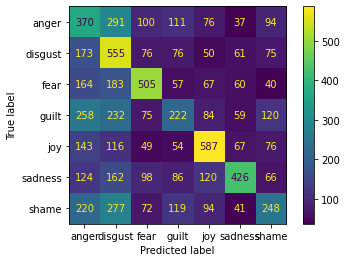

0.3875731772219266
(0.4058981961235949, 0.3867325495668609, 0.3861468420443529, None)


In [48]:
klasifikasi('poly')

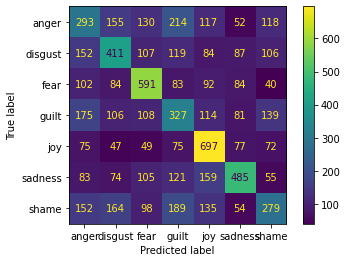

0.41019159127195315
(0.40524418304405657, 0.40925897998121485, 0.4044636203096435, None)


In [49]:
klasifikasi('rbf')

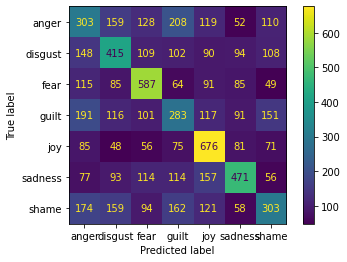

0.4042043640234167
(0.3990654573297111, 0.40320714345141717, 0.39892298544127536, None)


In [50]:
klasifikasi('linear')